Import All the necessary Libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

Set the directory of your train and test data

In [2]:
# Define the directory paths for training and testing data
train_dir = 'dataset/train'
test_dir = 'dataset/test'

Since I only have a small number of datasets, I will do data augmentation using transforms

In [3]:
# Define data transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(300),
    transforms.RandomAffine(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(300),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load data using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Creating a Fusion hybrid of ResNet and MobileNet

In [4]:
class ResNetBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)
    
class MobileNetResNetHybrid(nn.Module):
    def __init__(self, num_classes, freeze_mobilenet=True):
        super().__init__()

        # MobileNetV2 backbone
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.features = mobilenet.features  # output: [B, 1280, H, W]

        if freeze_mobilenet:
            for param in self.features.parameters():
                param.requires_grad = False


        # ResNet-style refinement
        self.resblock1 = ResNetBlock(1280)
        self.resblock2 = ResNetBlock(1280)

        # Classification head
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(1280, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)          # MobileNet features
        x = self.resblock1(x)         # ResNet refinement
        x = self.resblock2(x)

        x = self.pool(x)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


To create the class for Tsinelas and Sapatos

In [5]:
# Get the number of classes from the dataset
num_classes = len(train_dataset.classes)

# Initialize model, loss function, and optimizer
model = MobileNetResNetHybrid(num_classes=num_classes).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

c:\Users\Amnesia\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Amnesia\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training the Model

In [6]:
# Training Setup
num_epochs = 20
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

In [7]:
# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for images, labels in train_loader:
        images, labels = images.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_preds / total_preds * 100)
    
    # Evaluate on test set
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
            
            # Forward pass
            outputs = model(images)
            
            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
    
    test_losses.append(running_loss / len(test_loader))
    test_accuracies.append(correct_preds / total_preds * 100)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%")


Epoch [1/20], Train Loss: 0.9645, Train Accuracy: 58.33%, Test Loss: 1.4899, Test Accuracy: 50.00%
Epoch [2/20], Train Loss: 0.8886, Train Accuracy: 41.67%, Test Loss: 0.9433, Test Accuracy: 50.00%
Epoch [3/20], Train Loss: 0.7142, Train Accuracy: 62.50%, Test Loss: 0.6887, Test Accuracy: 60.00%
Epoch [4/20], Train Loss: 0.9012, Train Accuracy: 37.50%, Test Loss: 0.6784, Test Accuracy: 50.00%
Epoch [5/20], Train Loss: 0.8068, Train Accuracy: 50.00%, Test Loss: 0.7366, Test Accuracy: 50.00%
Epoch [6/20], Train Loss: 0.6390, Train Accuracy: 58.33%, Test Loss: 0.7203, Test Accuracy: 40.00%
Epoch [7/20], Train Loss: 0.7073, Train Accuracy: 54.17%, Test Loss: 0.7445, Test Accuracy: 40.00%
Epoch [8/20], Train Loss: 0.8365, Train Accuracy: 45.83%, Test Loss: 0.7834, Test Accuracy: 40.00%
Epoch [9/20], Train Loss: 0.6640, Train Accuracy: 58.33%, Test Loss: 0.8968, Test Accuracy: 50.00%
Epoch [10/20], Train Loss: 0.6892, Train Accuracy: 62.50%, Test Loss: 0.7602, Test Accuracy: 40.00%
Epoch [11

Making a Plot so that we can visually see how the accuracy and loss changes during the training

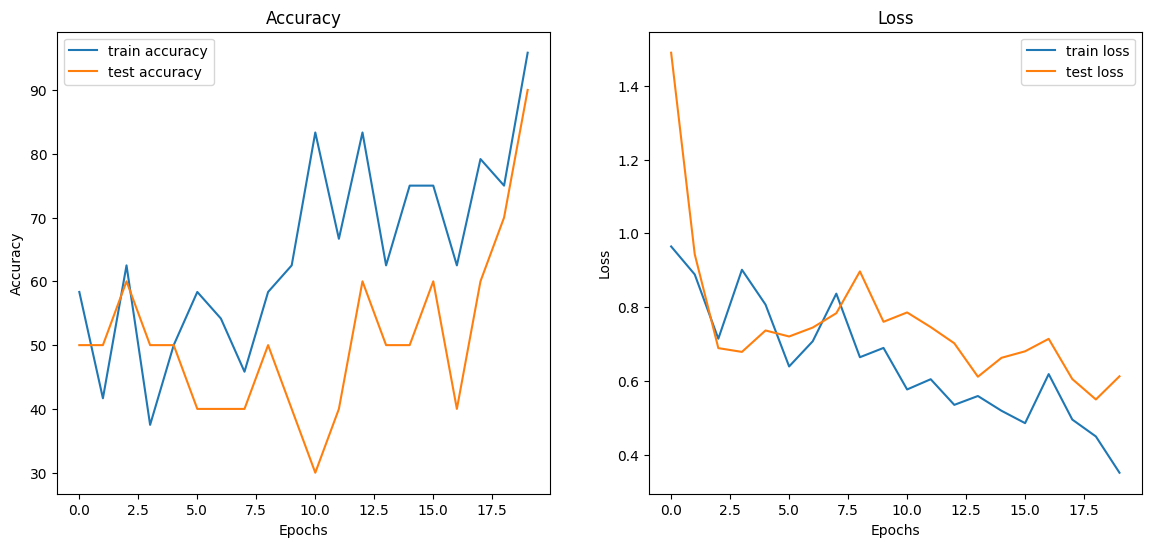

In [11]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy plot
axes[0].plot(train_accuracies, label='train accuracy')
axes[0].plot(test_accuracies, label='test accuracy')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss plot
axes[1].plot(train_losses, label='train loss')
axes[1].plot(test_losses, label='test loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()

Evaluating the model's accuracy

In [12]:
# Evaluate the model on the test set
model.eval()  # Set model to evaluation mode
correct_preds = 0
total_preds = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

test_acc = correct_preds / total_preds * 100
print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 90.00%


Testing how the model performs outside of the given datasets from training and testing

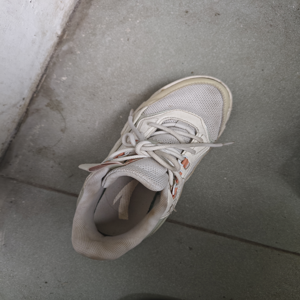

Predicted class: sapatos


In [35]:
# Test images for Prediction
img_path = 'dataset/test/sapatos/s_img (5).jpg'

# Preprocess the image
img = Image.open(img_path)
img = test_transforms(img).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

# Make a prediction
model.eval()
with torch.no_grad():
    predictions = model(img)
    predicted_class = torch.argmax(predictions, dim=1).item()

# Display the image and predicted class
img = Image.open(img_path)
img = img.resize((300, 300))
display(img)
print(f'Predicted class: {train_dataset.classes[predicted_class]}')

Same with above, but this one test in every image inside the folder instead of a single image

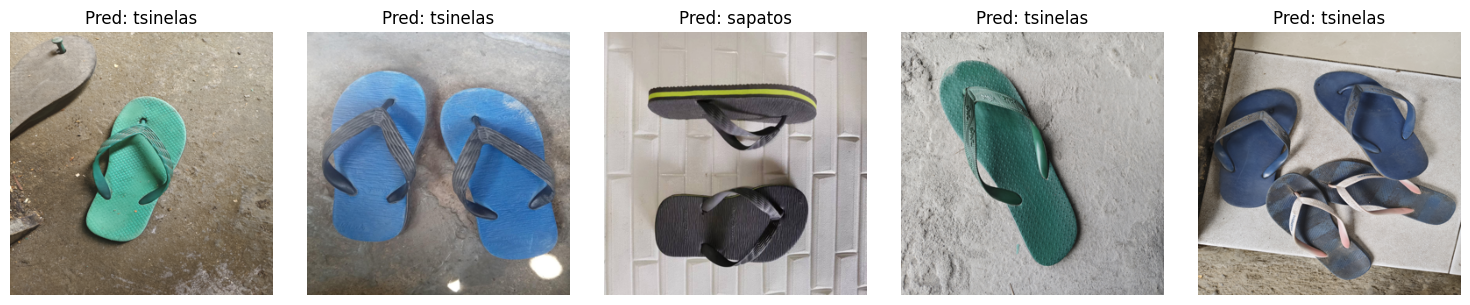

In [36]:
test_folder_path = 'dataset/test/tsinelas/'

# List all image files in the folder
image_files = [f for f in os.listdir(test_folder_path) if f.endswith(('jpg', 'jpeg', 'png'))]

# Set up the grid for plotting images
num_images = len(image_files)
cols = 5  # Number of columns in the grid
rows = (num_images + cols - 1) // cols  # Calculate the number of rows needed

# Create a figure with subplots for the grid
plt.figure(figsize=(cols * 3, rows * 3))  # Adjust size based on the grid dimensions

# Loop through each image file
for idx, img_file in enumerate(image_files):
    img_path = os.path.join(test_folder_path, img_file)

    # Preprocess the image
    img = Image.open(img_path)
    img_tensor = test_transforms(img).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

    # Make a prediction
    model.eval()
    with torch.no_grad():
        predictions = model(img_tensor)
        predicted_class = torch.argmax(predictions, dim=1).item()

    # Get the predicted class label
    predicted_label = train_dataset.classes[predicted_class]

    # Create subplot for this image
    plt.subplot(rows, cols, idx + 1)
    img_resized = img.resize((300, 300))  # Resize image for better display
    plt.imshow(img_resized)
    plt.axis('off')
    plt.title(f'Pred: {predicted_label}')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()